In [ ]:
!pip install yfinance
!pip install pandas_ta
!pip install alpaca-trade-api
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=4dfa5497505bed9ac0db7bc96a4c14d66c63d0a7bcfe9784ad79981da8a6b05e
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
from datetime import date, timedelta
import pandas as pd
import yfinance as yf
import numpy as np

In [ ]:
interval='1d'
df=yf.Ticker('DX-Y.NYB').history(start='2019-05-07',end='2023-05-07',interval=interval)
if(interval=='1d'):
  df.reset_index(inplace = True)
  df['Date'] = df['Date'].dt.strftime('%Y%m%d')
  df["Date"]=pd.to_datetime(df["Date"])
  df.set_index(['Date'],inplace=True)

df.drop(['Dividends','Stock Splits','Volume'], axis=1, inplace=True)
df.dropna(inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm_df = df.copy()
scaler=MinMaxScaler()
norm_df[norm_df.columns]=scaler.fit_transform(norm_df[norm_df.columns])
norm_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close
Date,,,,
2019-05-07,0.329714,0.317854,0.338723,0.331982
2019-05-08,0.331725,0.315452,0.340381,0.331577
2019-05-09,0.332127,0.316253,0.332919,0.321443
2019-05-10,0.326096,0.306245,0.328358,0.319822
2019-05-13,0.320869,0.303042,0.324212,0.319416
...,...,...,...,...
2023-05-01,0.496582,0.495997,0.514511,0.515201
2023-05-02,0.515883,0.504404,0.525290,0.507499
2023-05-03,0.504222,0.485188,0.491708,0.482367


In [ ]:
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, inplace=False, drop_targets=False):
  '''
  df: Pandas DataFrame of the univariate time-series
  tw: Training Window - Integer defining how many steps to look back
  pw: Prediction Window - Integer defining how many steps to predict

  returns: dictionary of sequences and targets for all sequences
  '''
  data = dict() # Store results into a dictionary
  L = len(df)
  for i in range(L-tw):
    # Option to drop target from dataframe
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)

    # Get current sequence  
    sequence = df[i:i+tw].values
    # Get values right after the current sequence
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class SequenceDataset(Dataset):

  def __init__(self, df):
    self.data = df

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [ ]:
BATCH_SIZE = 16
nhid = 50
nout = 4
sequence_len = 180
n_dnn_layers = 5
ninp = 6
split = 0.8

sequences = generate_sequences(norm_df, sequence_len, 1,norm_df.columns)

In [ ]:
norm_df

,Open,High,Low,Close
Date,,,,
2019-05-07,0.329714,0.317854,0.338723,0.331982
2019-05-08,0.331725,0.315452,0.340381,0.331577
2019-05-09,0.332127,0.316253,0.332919,0.321443
2019-05-10,0.326096,0.306245,0.328358,0.319822
2019-05-13,0.320869,0.303042,0.324212,0.319416
...,...,...,...,...
2023-05-01,0.496582,0.495997,0.514511,0.515201
2023-05-02,0.515883,0.504404,0.525290,0.507499
2023-05-03,0.504222,0.485188,0.491708,0.482367


In [ ]:
dataset = SequenceDataset(sequences)
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x, y = next(iter(trainloader))
y=y.reshape(16,4)
x.shape, y.shape

(torch.Size([16, 180, 4]), torch.Size([16, 4]))

In [ ]:
import gym
from gym import spaces
import numpy as np

class ForexTradingEnv(gym.Env):
    """
    A custom Gym environment for Forex trading.
    """
    def __init__(self, data, seq, capital=100):
        self.data = data
        self.capital = capital
        self.seq = seq
        self.current_step = seq - 1
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Discrete(2) # buy, sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5 * seq,))
        self.buy_times=0

    def _next_observation(self):
        obs = []
        for i in range(self.seq):
            obs += [
                self.data['Open'][self.current_step - i],
                self.data['High'][self.current_step - i],
                self.data['Low'][self.current_step - i],
                self.data['Close'][self.current_step - i],
                self.capital
            ]
        return np.array(obs)

    def _take_action(self, action):
        current_price = (self.data['Open'][self.current_step] + self.data['Close'][self.current_step]) / 2.0
        current_price=current_price*10
        if action == 0: # buy
             self.capital = self.capital- current_price
             self.buy_times+=1
             reward=-0.1
             return reward

        elif action == 1: # sell
            if(self.buy_times>0):
               self.capital = self.capital + current_price*self.buy_times
               self.buy_times=0
               reward = self.capital - 100
               return reward
            else:
               reward=0
               return reward   


    def step(self, action):
      if(action==1 or action==0):
        reward=self._take_action(action)
        self.current_step += 1
        done = self.current_step == len(self.data) - 1
        obs = self._next_observation()
        return obs, reward, done, {}
      else: print('your step must be 0 or 1!!!!!')  

    def reset(self):
        self.capital = 100
        self.current_step = self.seq - 1
        self.buy_times = 0
        return self._next_observation()

    def render(self, mode='human', close=False):
        pass


In [ ]:
env=ForexTradingEnv(norm_df,1)
env.reset()

array([  0.32971436,   0.31785413,   0.33872294,   0.33198198,
       100.        ])

In [ ]:
env.step(1)

(array([  0.33172493,   0.31545231,   0.34038135,   0.33157685,
        100.        ]),
 0,
 False,
 {})

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
def dqn(n_episodes=1000, max_t=len(norm_df), eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
        
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode==n_episodes:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            print('Saved')
            break 
    return scores
     

agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0)
scores = dqn()

Episode 100	Average Score: -72.37
Episode 200	Average Score: 118.21
Episode 300	Average Score: 53.60
Episode 400	Average Score: 73.46
Episode 500	Average Score: 29.30
Episode 600	Average Score: 10.01
Episode 700	Average Score: 8.86
Episode 800	Average Score: 1.30
Episode 900	Average Score: 2.94
Episode 1000	Average Score: 0.09

Environment solved in 900 episodes!	Average Score: 0.09
Saved


In [33]:
env=ForexTradingEnv(norm_df,1)
state = env.reset()
done = False
l=[]
while not done:
      env.render()
      action = env.action_space.sample()
      #action = agent.act(state)
      state, reward, done, info = env.step(action) 
      l.append(action)
env.close()   


In [36]:
index=[]
key=[]
for indexx,keyy in enumerate(l):
       index.append(indexx+1)
       key.append(keyy)
df['status']=2

for i in range(len(index)):
    for ii in range(len(df)):
        if(index[i]==ii):
            df['status'].iloc[ii]=key[i]
            break
                  

<ipython-input-36-26c731f08834>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'].iloc[ii]=key[i]


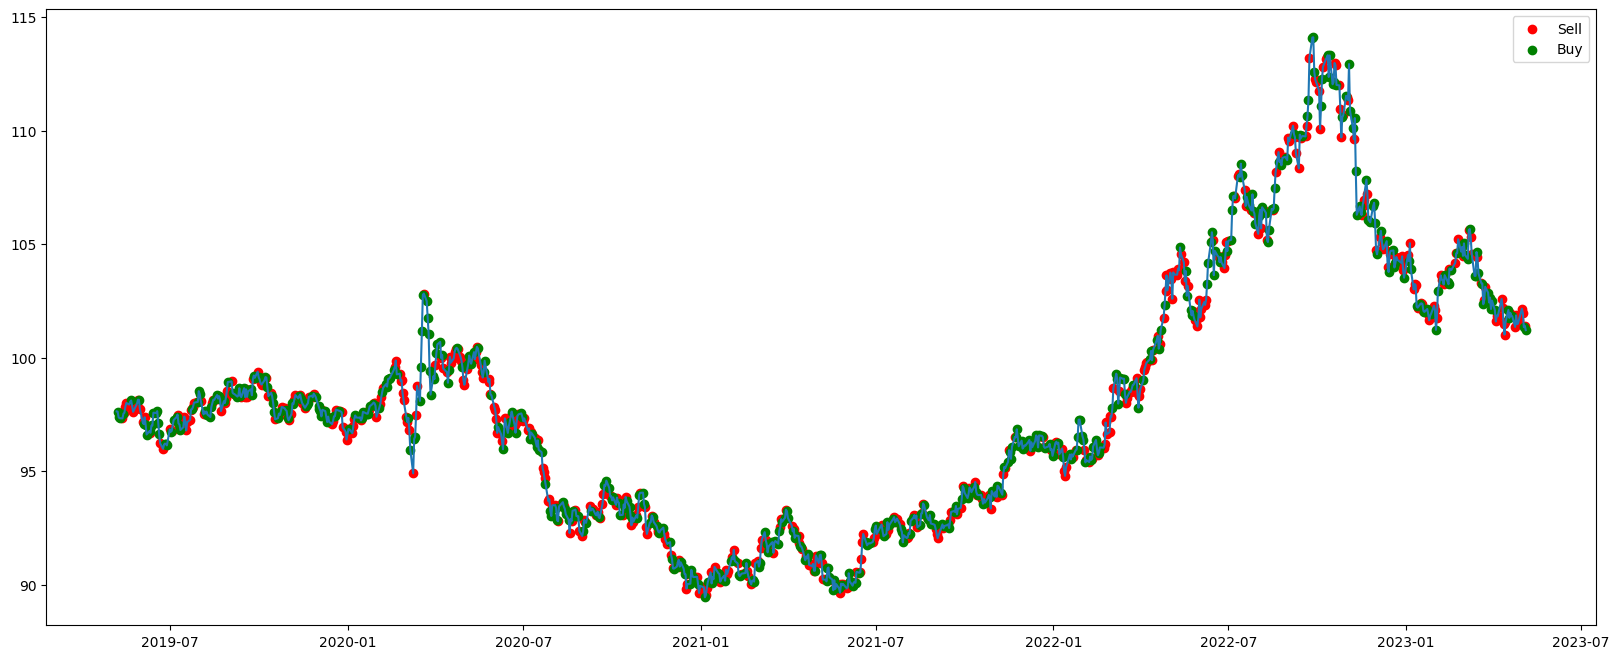

In [42]:
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(df.index,df.Close)
plt.scatter(df.index[df['status']==1],df['Close'][df['status']==1],c='red', label='Sell')
plt.scatter(df.index[df['status']==0],df['Close'][df['status']==0],c='green', label='Buy')
plt.legend()